# 2 - Representation Using SKLearn

In [1]:
import pandas as pd
ds_train = pd.read_pickle('pickles/ds_train.pkl')
ds_test = pd.read_pickle('pickles/ds_test.pkl')

In order to make predicitons on the text, it first needs to be converted into vector tokens the computer can understand. For that I am using `TFIDVectorizer`.<p>
Because I have two columns of text, one with stopwords and one without, and I want to see how this less computationally intensive process performs on each, I need two different instances of the vectorizer.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# setting thresholds for word occurence and relevance 
tfid_prepro = TfidfVectorizer(max_df=0.95,
        min_df=2)

tfid_nostop = TfidfVectorizer(max_df=0.95,
        min_df=2)

I also need to do `fit_transform` and `transform` for each one, as well as put the results into an array for storage.

In [3]:
# for the preprocess column (with stopwords)
# train
vec_train_prepro = tfid_prepro.fit_transform(ds_train['preprocess'])
train_prepro_array = vec_train_prepro.toarray()
# test
vec_test_prepro = tfid_prepro.transform(ds_test['preprocess'])
test_prepro_array = vec_test_prepro.toarray()

In [4]:
# for the no_stopword column (without stopwords)
# train
vec_train_nostop = tfid_nostop.fit_transform(ds_train['no_stopword'])
train_nostop_array = vec_train_nostop.toarray()
# test
vec_test_nostop = tfid_nostop.transform(ds_test['no_stopword'])
test_nostop_array = vec_test_nostop.toarray()

Quick check that there are the same number of columns on each...

In [5]:
print('train_preprep:',train_prepro_array.shape)
print('test_preprep:',test_prepro_array.shape)
print('train_nostop:',train_nostop_array.shape)
print('test_nostop:',test_nostop_array.shape)

train_preprep: (11314, 36428)
test_preprep: (7532, 36428)
train_nostop: (11314, 36297)
test_nostop: (7532, 36297)


### LDA Topic Modeling 

In [6]:
from sklearn.decomposition import LatentDirichletAllocation

Setting my n_components at 7 based on the labels I created earlier, and once again making two versions of the process; one for each category. (I did mess this up at once point and it broke everything for a solid half hour.)

In [7]:
n_cats = 7
lda_prepro = LatentDirichletAllocation(n_components=n_cats, random_state=42)
lda_nostop = LatentDirichletAllocation(n_components=n_cats, random_state=42)

In [8]:
# both fit_transforms
lda_train_prepro = lda_prepro.fit_transform(train_prepro_array)
lda_train_nostop = lda_nostop.fit_transform(train_nostop_array)

In [9]:
# both transforms
lda_test_prepro = lda_prepro.transform(test_prepro_array)
lda_test_nostop = lda_nostop.transform(test_nostop_array)

Displaying the most common words for each of the topics being generated:

In [10]:
def display_top_words(lda_model, vectorizer, n_top_words=10):
  # has the distribution per topic info
  topics = lda_model.components_

  # the actual word names
  feature_names = vectorizer.get_feature_names_out()

  # Print the top words for each topic
  for topic_idx, topic in enumerate(topics):
      print(f"Topic #{topic_idx + 1}:")
      top_words_idx = topic.argsort()[:-n_top_words - 1:-1]  # Get indices of top words
      top_words = [feature_names[i] for i in top_words_idx]
      print("Top words:", top_words)
      print()

In [12]:
display_top_words(lda_prepro, tfid_prepro)

Topic #1:
Top words: ['the', 'to', 'of', 'and', 'is', 'in', 'that', 'it', 'you', 'for']

Topic #2:
Top words: ['shameful', 'intellect', 'chastity', 'n3jxp', 'skepticism', 'surrender', 'gordon', 'banks', 'soon', 'lyme']

Topic #3:
Top words: ['ink', 'xdm', 'deskjet', 'tektronix', 'lcd', 'bj200', 'hello', 'ultrix', 'pcx', 'zeos']

Topic #4:
Top words: ['scsi1', '205', 'adl', 'scsi2', 'subscribe', 'intergraph', '35894', 'uunetingrb30catbytedtmedin', '7303169', 'medin']

Topic #5:
Top words: ['ditto', 'wtte', 'ites', 'comics', 'deluxe', 'pmp', 'adcom', 'sy', 'art', 'mercurys']

Topic #6:
Top words: ['rangers', 'alomar', 'pts', 'captain', 'flyers', 'baerga', 'period', 'champs', 'hartford', 'keller']

Topic #7:
Top words: ['retarded', 'motorcycling', 'gm', 'inguiry', 'renderman', 'cdt', 'boxscores', 'sipps', 'cdi', 'hernia']



In [11]:
display_top_words(lda_nostop,tfid_nostop)

Topic #1:
Top words: ['thanks', 'windows', 'card', 'drive', 'anyone', 'use', 'please', 'email', 'file', 'know']

Topic #2:
Top words: ['armenian', 'turkish', 'armenians', 'turks', 'armenia', 'lebanese', 'genocide', 'serdar', 'turkey', 'argic']

Topic #3:
Top words: ['shaftdrive', 'wheelie', 'retarded', 'wireframe', 'ampere', 'ohmite', 'unload', 'tom', 'bulb', 'tenants']

Topic #4:
Top words: ['leafs', 'rangers', 'game', 'detroit', 'season', 'hawks', 'scsi2', 'islanders', 'games', 'chicago']

Topic #5:
Top words: ['key', 'encryption', 'chip', 'clipper', 'keys', 'nsa', 'escrow', 'phone', 'algorithm', 'secure']

Topic #6:
Top words: ['would', 'one', 'dont', 'people', 'like', 'think', 'know', 'get', 'good', 'time']

Topic #7:
Top words: ['maxaxaxaxaxaxaxaxaxaxaxaxaxaxax', 'irq', 'test', 'mpeg', 'chop', 'com1', 'hillary', 'liturgy', 'gm', '16550']



Broadly, these look like they might makes sense, especially in the stopwords removed version. It's hard to draw any real conclusions without seeing if the categories actually are matching up. Topic 4 in the second output would make a lot of sense as 'rec',  for example. 

**Checking the output**<p>
First we need to get the predictions for each item and put them back onto the dataframes.

In [13]:
# getting the predictions
# train set
topic_train_pred_prepro = lda_train_prepro.argmax(axis=1)
topic_train_pred_nostop = lda_train_nostop.argmax(axis=1)
# test set
topic_test_pred_prepro = lda_test_prepro.argmax(axis=1)
topic_test_pred_nostop = lda_test_nostop.argmax(axis=1)

In [14]:
# attach to dataframes
# train set
ds_train['pred_prepro'] = topic_train_pred_prepro
ds_train['pred_nostop'] = topic_train_pred_nostop
# test set
ds_test['pred_prepro'] = topic_test_pred_prepro
ds_test['pred_nostop'] = topic_test_pred_nostop

In [15]:
display(ds_train.head(2))
display(ds_test.head(2))

,text,label,label_text,simple_topic,preprocess,no_stopword,pred_prepro,pred_nostop
0,I was wondering if anyone out there could enli...,7,rec.autos,3,i was wondering if anyone out there could enli...,wondering anyone could enlighten car saw day 2...,0,5
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware,1,a fair number of brave souls who upgraded thei...,fair number brave souls upgraded si clock osci...,0,5


,text,label,label_text,simple_topic,preprocess,no_stopword,pred_prepro,pred_nostop
0,I am a little confused on all of the models of...,7,rec.autos,3,i am a little confused on all of the models of...,little confused models 8889 bonnevilles heard ...,0,5
1,I'm not familiar at all with the format of the...,5,comp.windows.x,1,im not familiar at all with the format of thes...,im familiar format xface thingies seeing folks...,0,0


And then I can check the accuracy:

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
def check_accuracy(true,predicted):
  accuracy = accuracy_score(true,predicted)
  return accuracy

In [18]:
acc_train_prepro = check_accuracy(ds_train['simple_topic'],ds_train['pred_prepro'])
acc_train_nostop = check_accuracy(ds_train['simple_topic'],ds_train['pred_nostop'])
acc_test_prepro = check_accuracy(ds_test['simple_topic'],ds_test['pred_prepro'])
acc_test_nostop = check_accuracy(ds_test['simple_topic'],ds_test['pred_nostop'])

And also look at what categories this analysis actually predicted compared to what it was supposed to do.

In [31]:
import numpy as np
import matplotlib.pyplot as plt

([<matplotlib.axis.YTick at 0x17e05e82870>,
 [Text(0, 0, '0'),
  Text(0, 2000, '2000'),
  Text(0, 4000, '4000'),
  Text(0, 6000, '6000'),
  Text(0, 8000, '8000')])

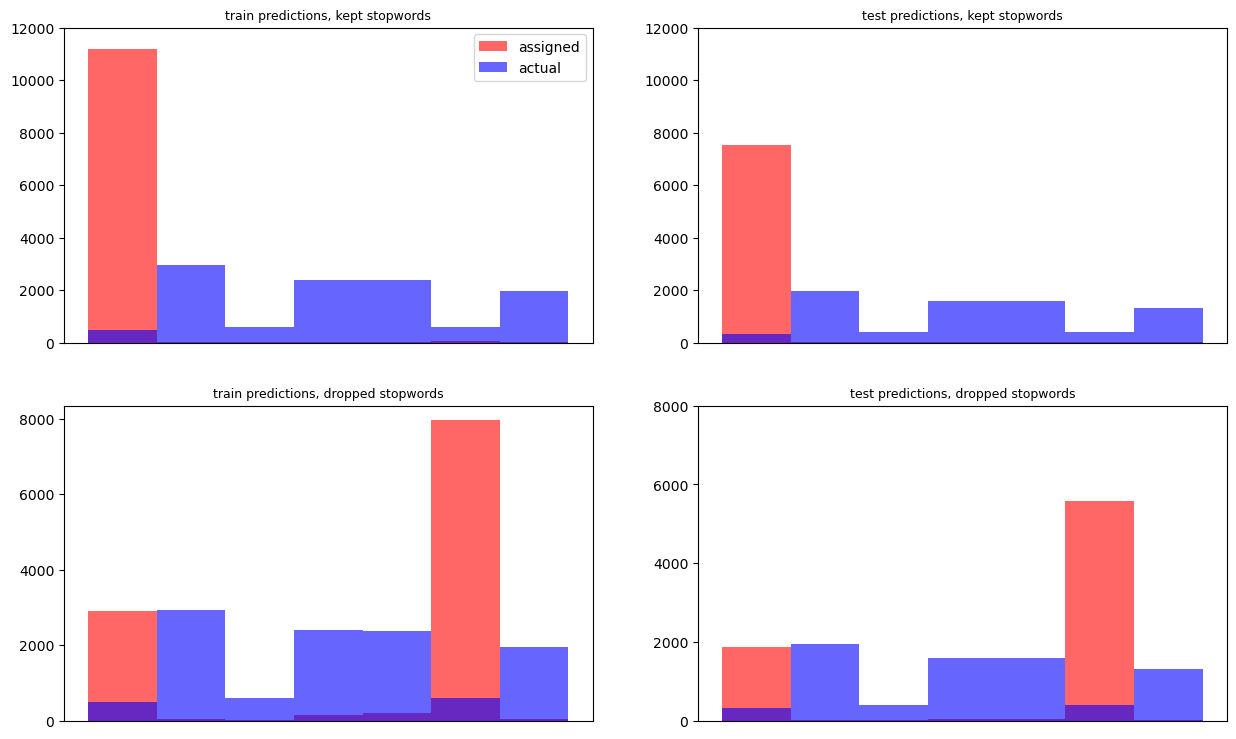

In [ ]:
plt.figure(figsize=(15,9))
plt.subplot(2,2,1)
plt.hist(ds_train['pred_prepro'],bins=7,color='red',alpha=0.6,label='assigned')
plt.hist(ds_train['simple_topic'],bins=7,color='blue',alpha=0.6,label='actual')
plt.title('train predictions, kept stopwords',fontsize=9)
plt.xticks([])
plt.yticks(np.arange(0,13000,2000))
plt.legend()

plt.subplot(2,2,2)
plt.hist(ds_test['pred_prepro'],bins=7,color='red',alpha=0.6,label='assigned')
plt.hist(ds_test['simple_topic'],bins=7,color='blue',alpha=0.6)
plt.title('test predictions, kept stopwords',fontsize=9)
plt.xticks([])
plt.yticks(np.arange(0,13000,2000))

plt.subplot(2,2,3)
plt.hist(ds_train['pred_nostop'],bins=7,color='red',alpha=0.6,label='assigned')
plt.hist(ds_train['simple_topic'],bins=7,color='blue',alpha=0.6,label='actual')
plt.title('train predictions, dropped stopwords',fontsize=9)
plt.xticks([])
plt.yticks(np.arange(0,8500,2000))

plt.subplot(2,2,4)
plt.hist(ds_test['pred_nostop'],bins=7,color='red',alpha=0.6,label='assigned')
plt.hist(ds_test['simple_topic'],bins=7,color='blue',alpha=0.6)
plt.title('test predictions, dropped stopwords',fontsize=9)
plt.xticks([])
plt.yticks(np.arange(0,8500,2000))

plt.savefig('charts/lda_output.png',bbox_inches='tight')

In [23]:
print('Accuracy without dropping stopwords:\n Train Set:',acc_train_prepro,'\n Test Set:',acc_test_prepro)
print('\nAccuracy with dropping stopwords:\n Train Set:',acc_train_nostop,'\n Test Set:',acc_test_nostop)

Accuracy without dropping stopwords:
 Train Set: 0.043839490896234755 
 Test Set: 0.042352628783855546

Accuracy with dropping stopwords:
 Train Set: 0.06708502739968181 
 Test Set: 0.058682952734997344


The accuracy is higher when the stopwords are dropped, but it is still significantly worse than random chance, which is 1/7, or 0.14. So this simple model does not do a good job of evaluating topics, unless something went very wrong in my setup, which is entirely possible. Now it's time to move on to a more complex model that will hopefully do a much better job of analyzing the data. 